/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


importing Jupyter notebook from karger_algorithm.ipynb


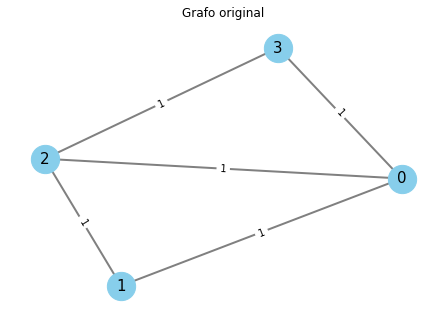

Iteracion 0


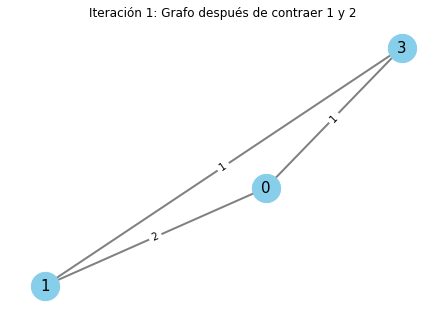

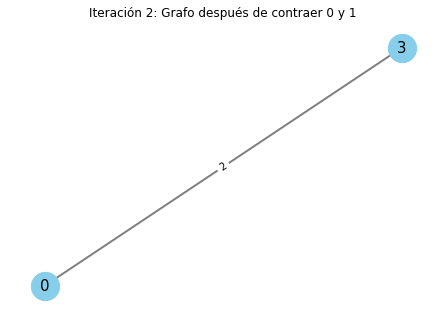

Iteracion 1


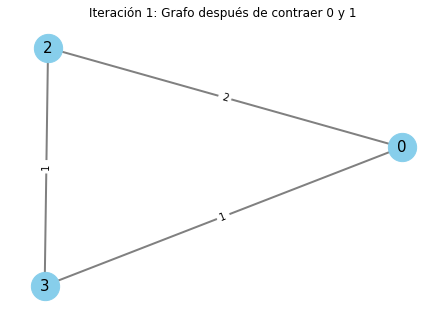

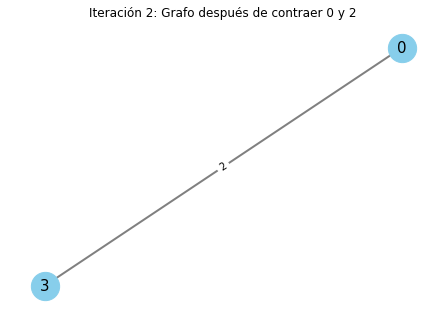

El corte mínimo encontrado por el algoritmo de Karger es: 2
1


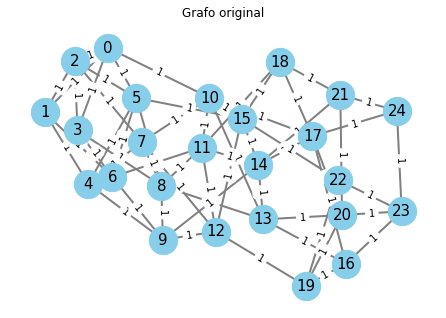

El corte mínimo encontrado por el algoritmo de Karger es: 3


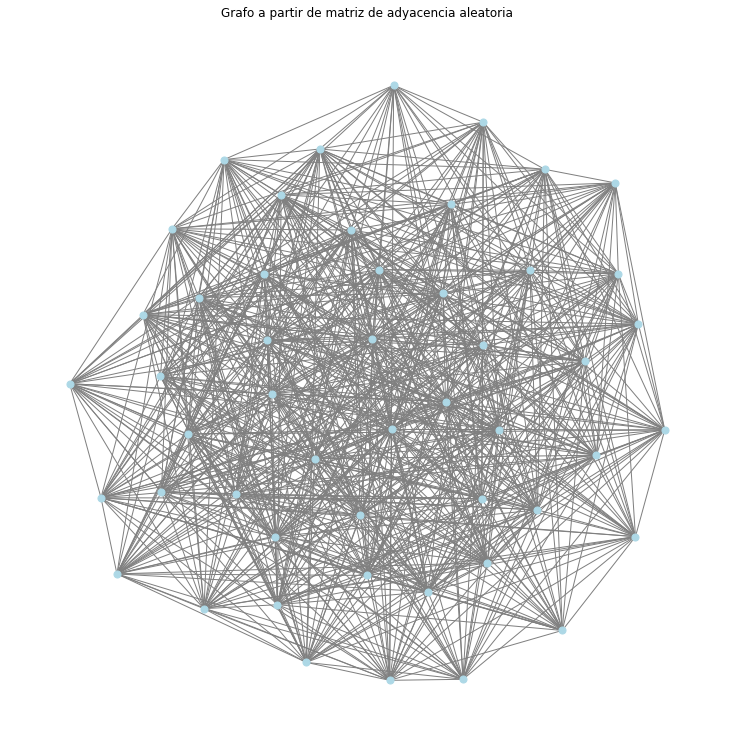

El corte mínimo encontrado por el algoritmo de Karger es: 25


In [1]:
import networkx as nx 
import matplotlib.pyplot as plt 
import random
from qiskit import *
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import DensityMatrix
from qiskit_ibm_runtime import QiskitRuntimeService
import numpy as np
 

import import_ipynb
import karger_algorithm  


function `circuit_to_graph` takes a Quantum Circuit and returns a graph where each blue node represents a gate and each green edge represents a qubit.

In [73]:
def circuit_to_graph(qc):
    n_qubits = qc.num_qubits
    
    # Create a graph
    G = nx.Graph()
    
    # Add nodes for the qubits and the top nodes
    qubit_top_nodes = []
    for qubit in range(n_qubits):
        qubit_top_node = f'q_top_{qubit}'
        G.add_node(f'q_{qubit}', label=f'q-{qubit}')
        if qubit == 2:    
            G.add_node(qubit_top_node, label=f'A')
        elif qubit == 3:    
            G.add_node(qubit_top_node, label=f'B')
        else:
            G.add_node(qubit_top_node)
        qubit_top_nodes.append(qubit_top_node)  
            
    # Add nodes and edges for two-qubit gates with unique identifiers
    gate_counter = 0
    previous_gate_nodes = {}
    gate_colors = {
        'cx': 'lightgreen',
        'cz': 'red',
        'swap': 'green',
        # Add more colors for other gates if needed
    }
    
    for gate, qubits, clbits in qc.data:
        if gate.name in gate_colors: 
            qubit_indices = [qc.qubits.index(qubit) for qubit in qubits]
            gate_id = f'{gate.name.upper()}-{gate_counter}'
            G.add_node(gate_id,label=gate_counter , index=gate_counter, color=gate_colors[gate.name])
            
            for qubit_index in qubit_indices:
                if qubit_index == 0 or qubit_index == n_qubits - 1:
                    # Si el qubit es el primero o el último, asigna peso alto
                    if qubit_index in previous_gate_nodes:
                        # Check if an edge already exists between the current gate and the previous one
                        if G.has_edge(gate_id, previous_gate_nodes[qubit_index]):
                            # If the edge exists, increase its weight by 1 
                            G[gate_id][previous_gate_nodes[qubit_index]]['weight'] = float('inf')
                            G[gate_id][previous_gate_nodes[qubit_index]]['weight'] += 1
                            
                        else:
                            # Otherwise, create a new edge with big weight 
                            G.add_edge(gate_id, previous_gate_nodes[qubit_index], weight=float('inf'))
                    else:
                        G.add_edge(gate_id, f'q_{qubit_index}', weight=float('inf'))
                        
                else:
                    # For other qubits, assign weight 1
                    if qubit_index in previous_gate_nodes:
                        # Check if an edge already exists between the current gate and the previous one
                        if G.has_edge(gate_id, previous_gate_nodes[qubit_index]):
                            # If the edge exists, increase its weight by 1
                            G[gate_id][previous_gate_nodes[qubit_index]]['weight'] += 1
                        else:
                            # Otherwise, create a new edge with weight 1
                            G.add_edge(gate_id, previous_gate_nodes[qubit_index], weight=1)
                    else:
                        G.add_edge(gate_id, f'q_{qubit_index}', weight=1)
                    
                # Update the previous_gate_nodes for this qubit
                previous_gate_nodes[qubit_index] = gate_id
            
            gate_counter += 1

    # Connect the last nodes of the gates to the upper qubits
    for qubit_index in range(n_qubits):
        if qubit_index == 0 or qubit_index == n_qubits - 1:
            # If the qubit is the first or last, assign weight 1000 to the edge
            if qubit_index in previous_gate_nodes:
                G.add_edge(previous_gate_nodes[qubit_index], f'q_top_{qubit_index}', weight=float('inf'))
            else:
                G.add_edge(f'q_{qubit_index}', f'q_top_{qubit_index}', weight=float('inf'))
        else:
            # For other qubits, assign weight 1
            if qubit_index in previous_gate_nodes:
                G.add_edge(previous_gate_nodes[qubit_index], f'q_top_{qubit_index}', weight=1)
            else:
                G.add_edge(f'q_{qubit_index}', f'q_top_{qubit_index}', weight=1)

    # Fijar la posición de los nodos
    pos = {}
    
    # Posiciones de los qubits en una fila en la parte inferior
    for i in range(n_qubits):
        pos[f'q_{i}'] = (i, 0)
        pos[f'q_top_{i}'] = (i, gate_counter + 2)  # Posiciones de los qubits superiores

    # Posiciones de las compuertas en filas superiores
    gate_counter = 0
    for gate, qubits, clbits in qc.data:
        if gate.name in gate_colors:
            qubit_indices = [qc.qubits.index(qubit) for qubit in qubits]
            gate_id = f'{gate.name.upper()}-{gate_counter}'
            pos[gate_id] = (sum(qubit_indices) / len(qubit_indices), gate_counter + 1)
            gate_counter += 1

    return G, pos, qubit_top_nodes

def draw_circuit_graph(G, pos, u = None, v = None):
    
        plt.figure(figsize=(7, 7))
        node_colors = [G.nodes[node].get('color', 'skyblue') for node in G.nodes()]
        labels = nx.get_edge_attributes(G, 'weight')
        nx.draw(G, pos, with_labels=True, labels=nx.get_node_attributes(G, 'label'), node_color=node_colors, edge_color="black", node_size=1500, font_size=9, font_weight="bold", width=3.5)
        if u is not None and v is not None:
            nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
            #plt.title("Graph before merged the nodes " + str(u) + " y " + str(v))
        else:
            plt.title("Grafo Representando el Circuito Cuántico")

Variation of the Karger algorithm implemented in minimal cut of Quantum circuits

In [3]:

def karger_min_cut_circuit(qc, bool_plot, exclude_nodes):
    
    G, pos, qubit_top_nodes = circuit_to_graph(qc)
    
    G = G.copy()  # Copy the graph to avoid modifying the original graph
    
    if exclude_nodes is None:
        exclude_nodes = []
    
    # Add an edge with weight 0 between the two excluded nodes 
    
    exclude_nodes = [f'q_top_{node}' for node in exclude_nodes]
    G.add_edge(exclude_nodes[0], exclude_nodes[1], weight=0)    

    # Merge the top qubits with the adjacent excluded qubit
    
    for i in range(len(qubit_top_nodes) - 2):
    
        qubit_top_node = qubit_top_nodes[i]
        qubit_top_node_num = int(qubit_top_node.split('_')[-1])
        
        if qubit_top_node_num < int(exclude_nodes[0].split('_')[-1]):
            node_to_merge = f'q_top_{qubit_top_node_num + 1}'
            if node_to_merge in G and qubit_top_node in G:
                G = karger_algorithm.merge_nodes(G, node_to_merge, qubit_top_node)
            
        else:
            qubit_top_node = qubit_top_nodes[i +2]
            if exclude_nodes[1] in G and qubit_top_node in G:
                G = karger_algorithm.merge_nodes(G, exclude_nodes[1], qubit_top_node)

    iteration = 1
    
        
    # While there are more than two nodes in the graph
    
    while len(G.nodes) > 2:
        
        
        if len(G.nodes) == 3:

            u = random.choice(exclude_nodes)
            v = next(node for node in G.nodes if node not in exclude_nodes)
            
            if bool_plot:
                draw_circuit_graph(G, pos, u, v)
 
        
        else:   
            # Filter edges that do not involve the excluded nodes
            edges = [(u, v) for u, v in list(G.edges) if u not in exclude_nodes or v not in exclude_nodes]

            u, v = random.choice(edges)
            if v == exclude_nodes[0] or v == exclude_nodes[1]:
                u, v = v, u
                
            if bool_plot:
                draw_circuit_graph(G, pos, u, v)
            
        G = karger_algorithm.merge_nodes(G, u, v)
        
        iteration += 1

    if bool_plot:
        draw_circuit_graph(G, pos, u, v)
    
    # Encontramos los dos nodos restantes y calculamos el peso total de las aristas entre ellos
    remaining_nodes = list(G.nodes)
    u, v = remaining_nodes
    
    cut_weight = G[u][v].get('weight', 1)
    return cut_weight

Exemple of Karger modified algorithm to find the minimal cut of a graph.

In [11]:
#Create my circuit
n_qubits = 5
n_partition = 1

qc = QuantumCircuit(n_qubits)
# qc.h(0)
# qc.cx(6,7)
# qc.cx(7, 8)
# for i in range(9):
#     qc.cx(i, i+1)

# qc.cx(3, 4)
# qc.cx(4, 5)
# qc.swap(4, 5)

# qc.cx(0, 1)
# qc.cx(0, 1)
# qc.cx(0, 1)
# qc.cx(1, 2)
# qc.cx(0, 1)
# qc.cx(0, 1)
# qc.cx(1, 2)
# qc.cx(1, 2)
# qc.cx(1, 2)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 4)
qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(0, 1) 
qc.cx(3, 4)
qc.cx(1, 2)


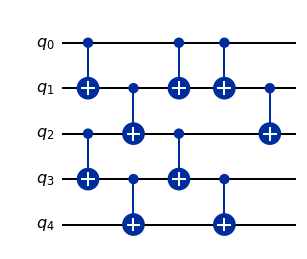

[3]
El corte minimo pasando por los quitbs [2, 3] es: 3


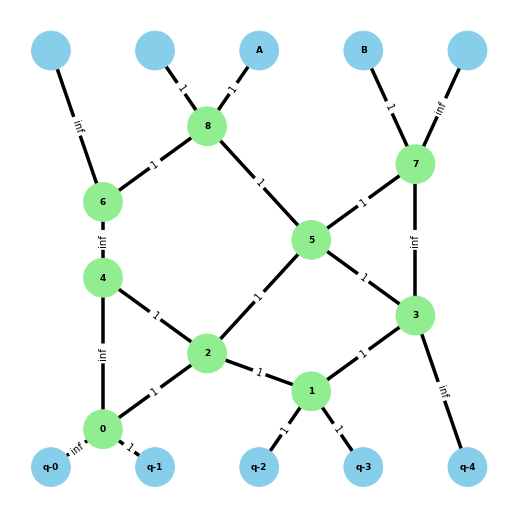

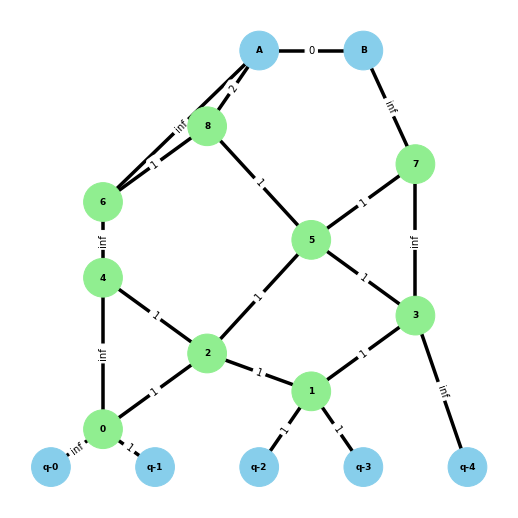

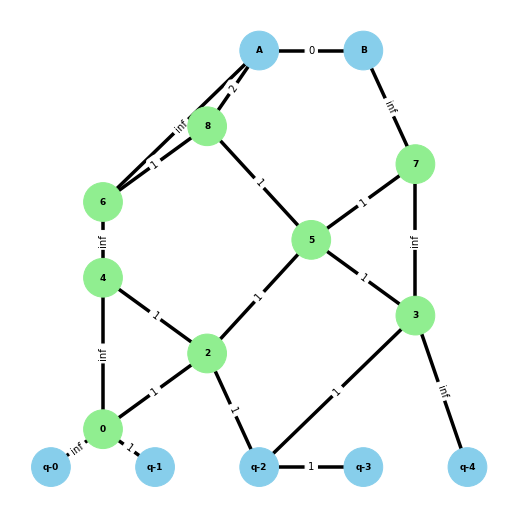

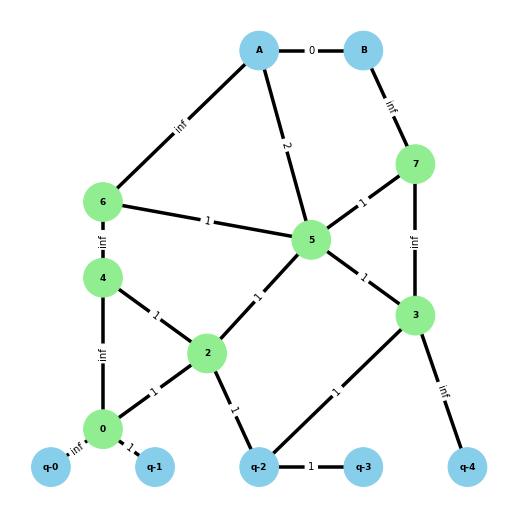

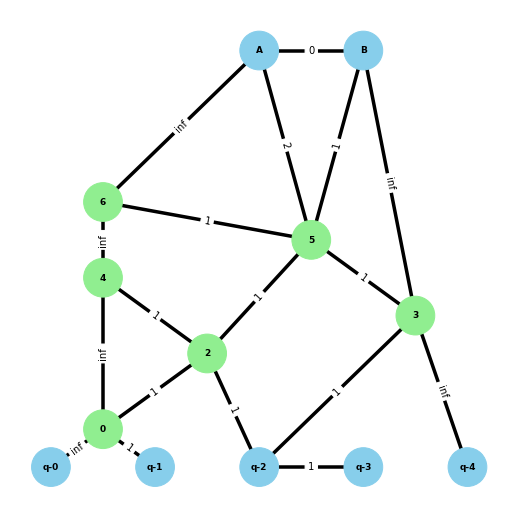

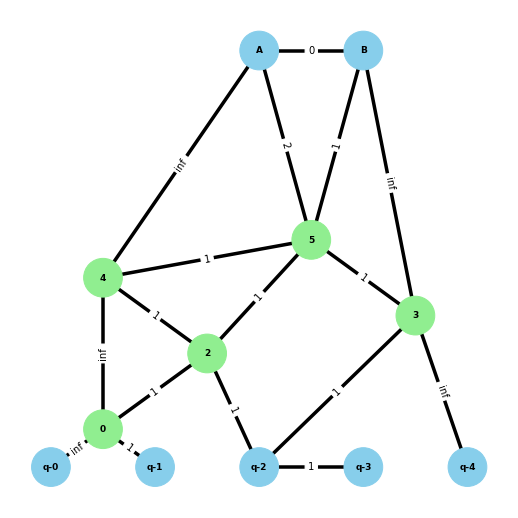

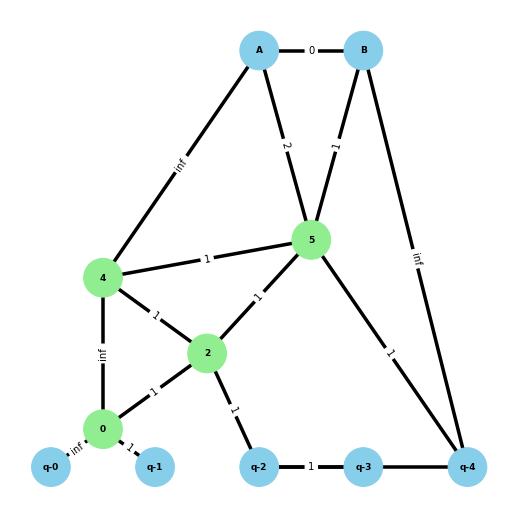

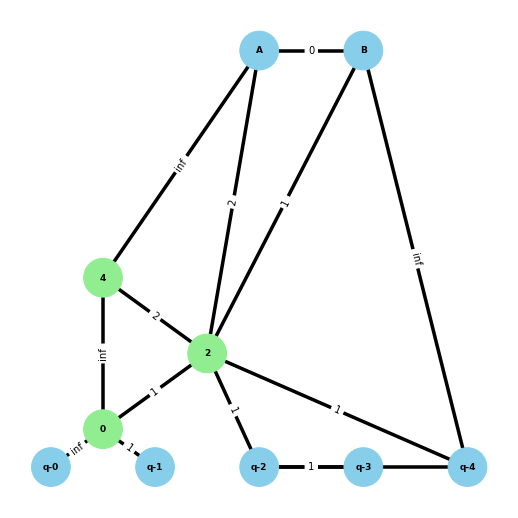

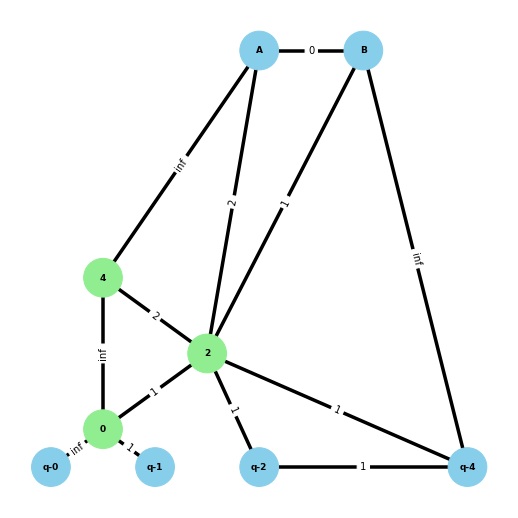

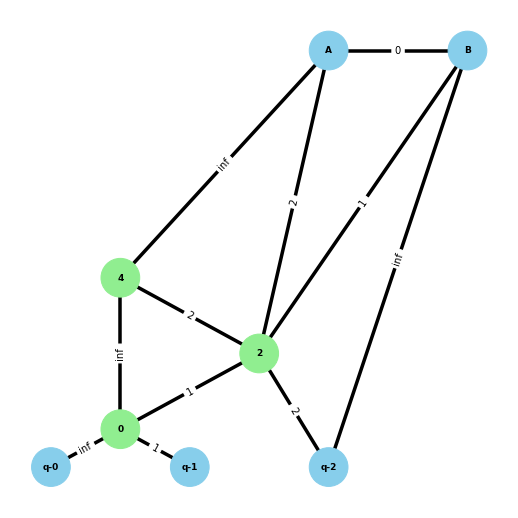

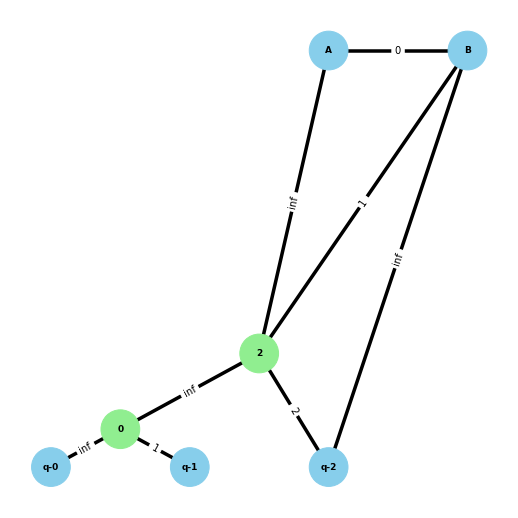

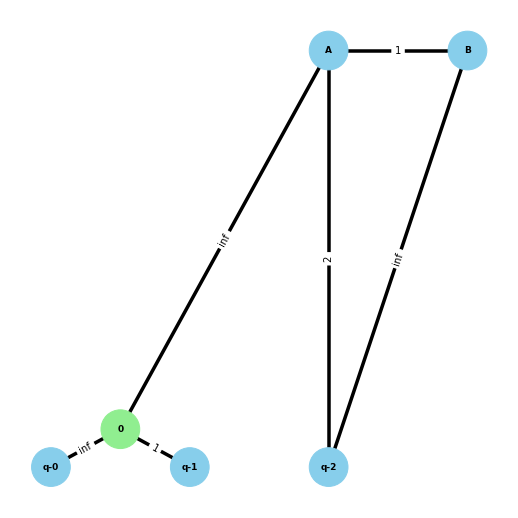

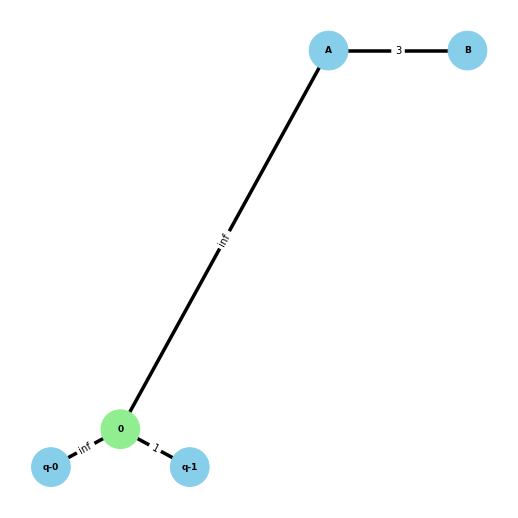

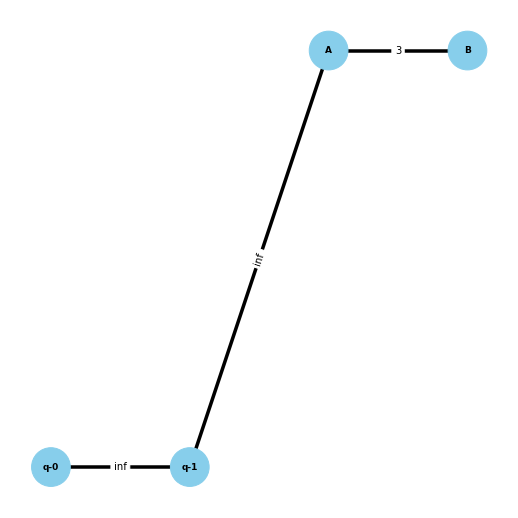

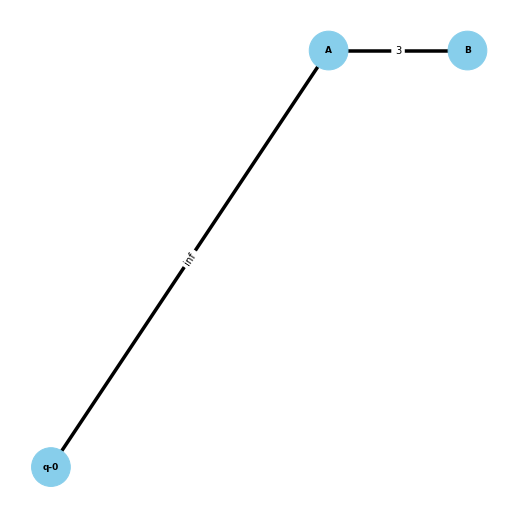

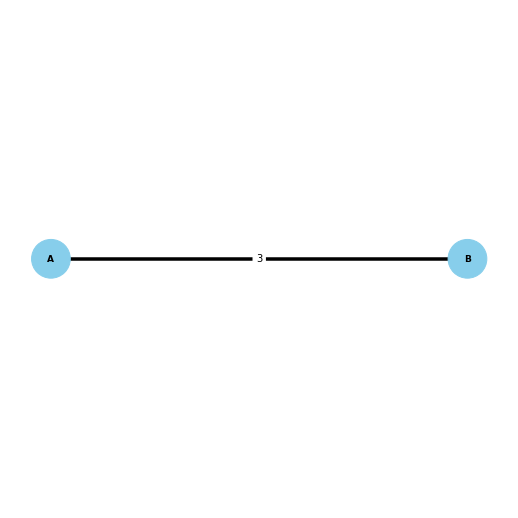

In [78]:

G, pos, qubit_top_nodes = circuit_to_graph(qc)

# Show the circuit and graph
display(qc.draw(output='mpl'))
plt.show()
draw_circuit_graph(G, pos,1,1)

#Execute the algorithm
exclude_nodes = [2, 3]
trials = 1
cuts = []

for _ in range(trials):
    cut = karger_min_cut_circuit(qc, True, exclude_nodes)
    cuts.append(cut)
    min_cut = min(cuts) 
    
print(cuts)
cut = karger_min_cut_circuit(qc, False, exclude_nodes)

print(f"El corte minimo pasando por los quitbs {exclude_nodes} es: {min_cut}")

Another example

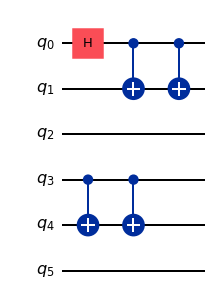

El corte minimo pasando por los quitbs [0, 1] es: 10002


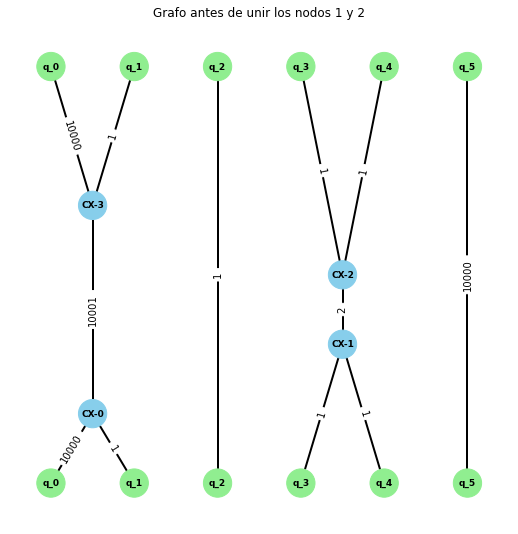

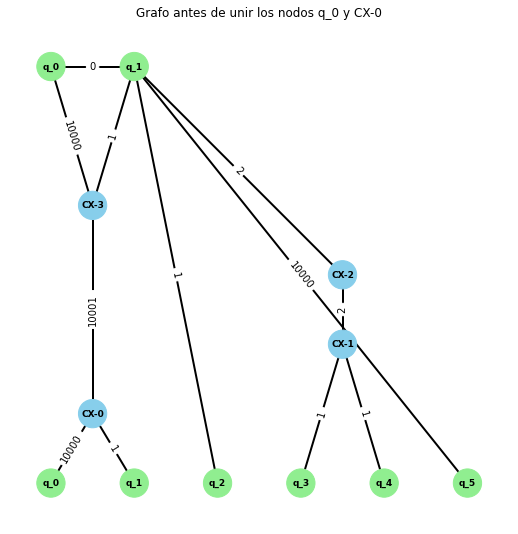

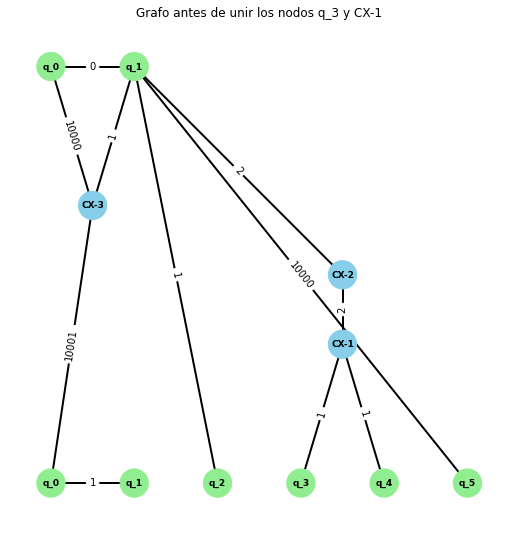

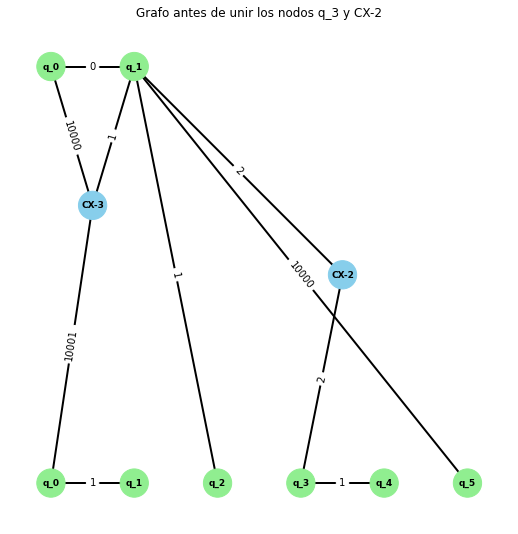

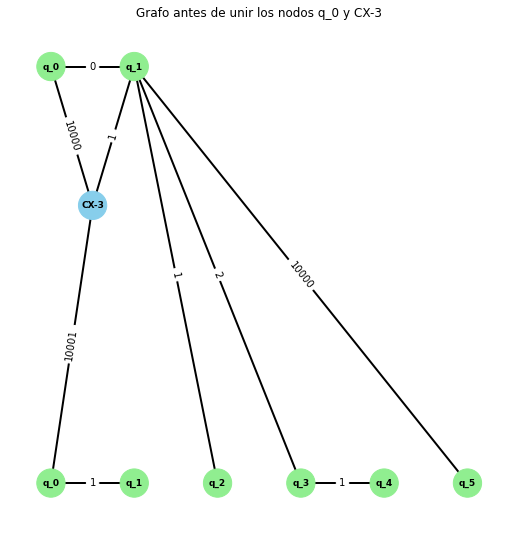

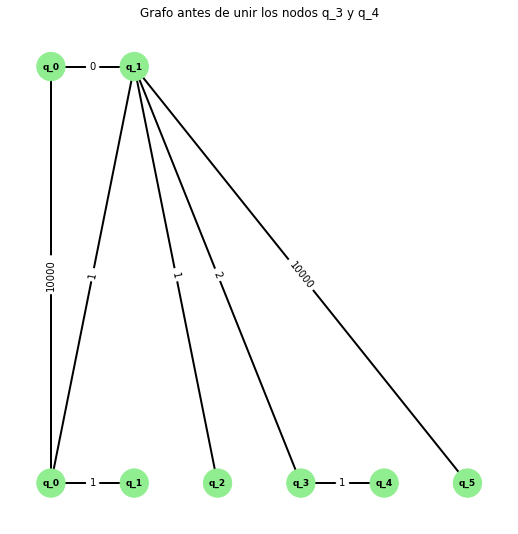

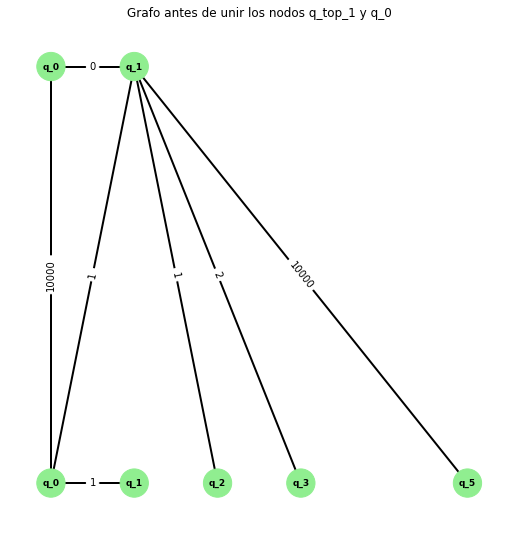

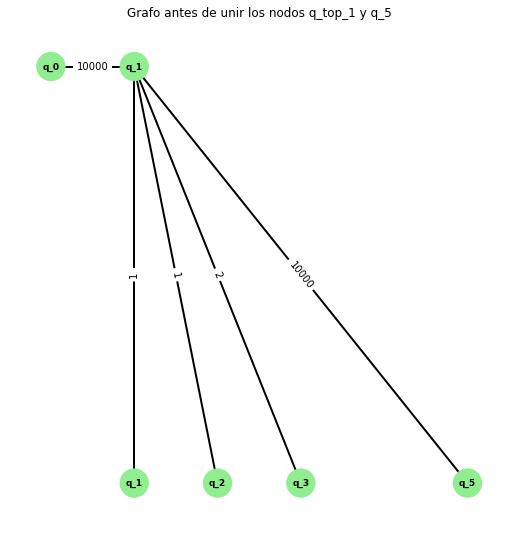

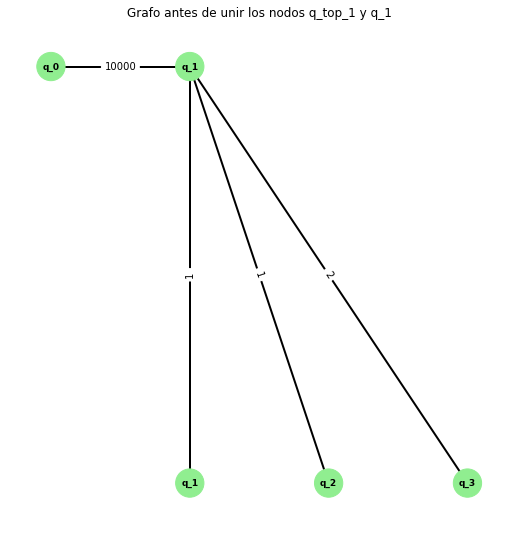

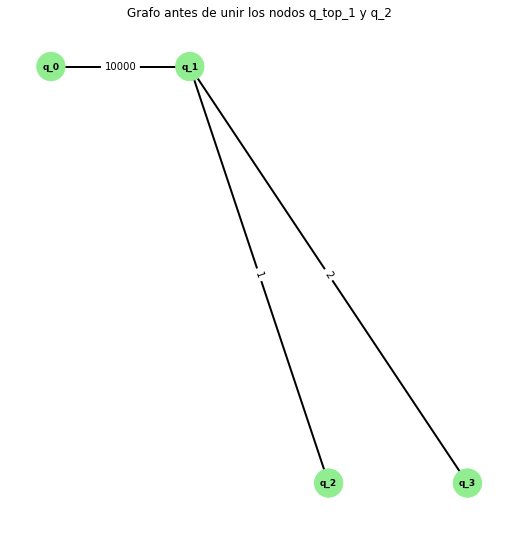

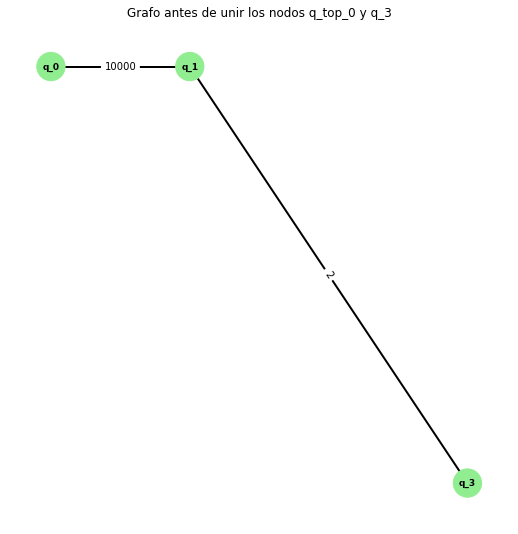

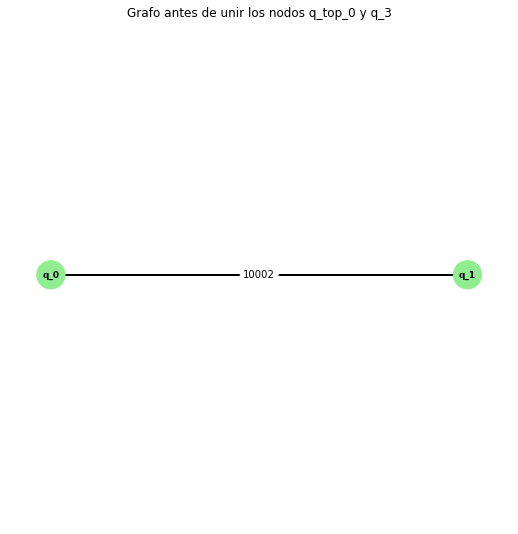

In [6]:
qc1 = QuantumCircuit(6)
qc1.h(0)
qc1.cx(0, 1)
qc1.cx(3, 4)
qc1.cx(3, 4)
qc1.cx(0, 1)

G, pos, qubit_top_nodes = circuit_to_graph(qc1)

# Show the circuit and graph
display(qc1.draw(output='mpl'))
plt.show()
draw_circuit_graph(G, pos, 1, 2)

exclude_nodes = [0,1]
trial = 1
min_cut = float('inf')
    
for _ in range(trial):
    cut = karger_min_cut_circuit(qc1, True, exclude_nodes)
    min_cut = min(min_cut, cut) 
    
print(f"El corte minimo pasando por los quitbs {exclude_nodes} es: {min_cut}")